# Descarga del dataset
---



In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

from typing import Literal
ds = tfds.load('ag_news_subset', split='train', shuffle_files=True)

ds = ds.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
for example in ds.take(1):
  description, label, title = example["description"], example["label"], example["title"]


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.PNM23X_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.PNM23X_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


# Configuracion del entorno
---

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

Physical devices cannot be modified after being initialized


In [3]:
!pip install wordcloud

In [4]:
 tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Modelando el dataset para el entrenamiento con palabras y caracteres
---

In [5]:

import os
from typing import Literal
import re

INPUT_FILES = ["all_ids.txt","all_text.txt", "all_words.txt"]

if not os.path.exists(INPUT_FILES[0]) or not os.path.exists(INPUT_FILES[1]) or not os.path.exists(INPUT_FILES[2]):
  vocab = []
  words = []
  all_text  = []

  for text in ds:
    for t in text["description"]:
      l = t.numpy().decode('UTF-8')
      clean_string = [s for s in l if s.isalnum() or s.isspace() or s in [".", ",", "'" ]]
      l = "".join(clean_string).replace("#39;", "'")

      vocab += list(l)
      vocab = list(set(vocab))

      #split_words = [a for a in re.split(r'(\s|\,|\.)', l.strip()) if a]
      #words += split_words
      words += l.split(" ")
      words = list(set(words))

      all_text.append(l)

  with open(INPUT_FILES[0], 'w') as f:
    f.write("\n".join(vocab) )
  with open(INPUT_FILES[1], 'w') as f:
    f.write("\n".join(all_text))
  with open(INPUT_FILES[2], 'w') as f:
    f.write("\n".join(words) )
else:
  with open(INPUT_FILES[0], 'r') as f:
    vocab = f.read()
    vocab = set(vocab)
  with open(INPUT_FILES[1], 'r') as f:
    all_text = f.read()
  with open(INPUT_FILES[2], 'r') as f:
    words = f.read()
    words = list(set(words.split("\n")))

print(f"{len(vocab)} unique tokens")
print(f"{len(words)} unique words")
print(f"{len(all_text)} total text")

all_text_list = all_text
all_text = "".join(all_text)



67 unique tokens
143025 unique words
22957431 total text


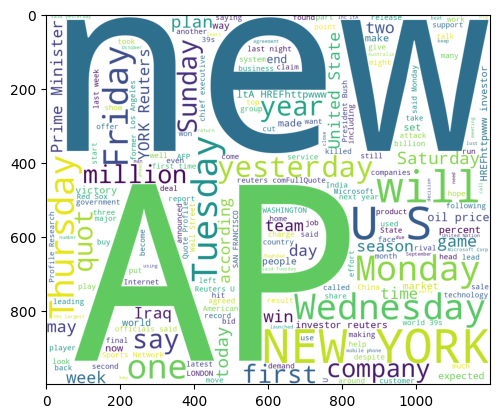

In [ ]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

wordcloud = WordCloud(background_color="white",
                          width=1200, height=1000,
                          #stopwords=STOPWORDS
                         ).generate(all_text)
plt.imshow(wordcloud)

# Definicion de funciones para el tokenizador de caracteres
---

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

## Ejemplo de funciones de tokenizacion
---

In [ ]:
example_texts = ['abcdefg', 'xyz']

chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
print(chars)

ids = ids_from_chars(chars)
print(ids)
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars = chars_from_ids(ids)
print(chars)

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>
<tf.RaggedTensor [[42, 28, 11, 51, 15, 55, 62], [37, 26, 8]]>
<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>


# Generamos el DataSet
---

Usamos batches de 100 caracteres

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(all_text, 'UTF-8'))
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

 
N
A
I
R
O
B
I
,
 


In [ ]:
seq_length = 200
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)
for seq in sequences.take(1):
  print(chars_from_ids(seq))
  print(text_from_ids(seq).numpy())

tf.Tensor(
[b' ' b'N' b'A' b'I' b'R' b'O' b'B' b'I' b',' b' ' b'K' b'e' b'n' b'y'
 b'a' b' ' b'R' b'e' b'u' b't' b'e' b'r' b's' b' ' b' ' b'T' b'h' b'e'
 b' ' b'S' b'u' b'd' b'a' b'n' b'e' b's' b'e' b' ' b'g' b'o' b'v' b'e'
 b'r' b'n' b'm' b'e' b'n' b't' b' ' b'a' b'n' b'd' b' ' b'i' b't' b's'
 b' ' b' ' b's' b'o' b'u' b't' b'h' b'e' b'r' b'n' b' ' b'r' b'e' b'b'
 b'e' b'l' b' ' b'o' b'p' b'p' b'o' b'n' b'e' b'n' b't' b's' b' ' b's'
 b'i' b'g' b'n' b'e' b'd' b' ' b'a' b' ' b'p' b'l' b'e' b'd' b'g' b'e'
 b' ' b'F' b'r' b'i' b'd' b'a' b'y' b' ' b't' b'o' b' ' b'c' b'o' b'm'
 b'p' b'l' b'e' b't' b'e' b' ' b'a' b'n' b' ' b' ' b'a' b'g' b'r' b'e'
 b'e' b'm' b'e' b'n' b't' b' ' b't' b'o' b' ' b'e' b'n' b'd' b' ' b'a'
 b' ' b'2' b'1' b'y' b'e' b'a' b'r' b'o' b'l' b'd' b' ' b'c' b'i' b'v'
 b'i' b'l' b' ' b'w' b'a' b'r' b' ' b'b' b'y' b' ' b'D' b'e' b'c' b'e'
 b'm' b'b' b'e' b'r' b' ' b'3' b'1' b'.' b'\n' b'R' b'e' b'u' b't' b'e'
 b'r' b's' b' ' b' ' b'N' b'a' b'm' b'i' b'b' b'i' b'a' b'n' b' '

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

## Mapeamos los registros del dataset con la funcion split
---
Asignamos la funcion split_input_target a nuestro dataset para que desplaze un caracter por cada registro devolviendo un par de input, target

In [ ]:
dataset = sequences.map(split_input_target)
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b' NAIROBI, Kenya Reuters  The Sudanese government and its  southern rebel opponents signed a pledge Friday to complete an  agreement to end a 21yearold civil war by December 31.\nReuters  Namibian beef '
Target: b'NAIROBI, Kenya Reuters  The Sudanese government and its  southern rebel opponents signed a pledge Friday to complete an  agreement to end a 21yearold civil war by December 31.\nReuters  Namibian beef c'


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## Generando batches en le dataset
---
Redefinimos nuestro dataset para generar batches de 64 registros y sequencias de 100 caracteres ( shape=(64,100) )

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    #.shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 200), dtype=tf.int64, name=None), TensorSpec(shape=(64, 200), dtype=tf.int64, name=None))>

## Definimos el tamano de nuestro Vocabulario
---
Definimos el tamano de nuestro vocabulario con el cual vamos a trabajar y asignar a la salida de nuestro modelo y a la capa de embeddings

In [ ]:
vocab_size = len(ids_from_chars.get_vocabulary())


# Models
---

## Definiendo layers para los modelos y embeddings
---

In [ ]:
embedding_dim = 256
gru_rnn_units = 1024
lstm_rnn_units = 64

## GRU
---

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

class TpFinalEx2ModelGRU(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'
                                   )

    # self.gru2 = tf.keras.layers.GRU(rnn_units,
    #                                return_sequences=True,
    #                                return_state=True
    #                                )

    #self.dropout = tf.keras.layers.Dropout(0.1)

    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)

    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    # x, states = self.gru2(x, initial_state=states, training=training)
    # x = self.dropout(x, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

# LSTM
---

In [ ]:
class TpFinalEx2ModelLSTM(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    self.lstm1 = tf.keras.layers.LSTM(rnn_units,
                                return_sequences=True,
                                return_state=True)

    # self.lstm2 = tf.keras.layers.LSTM(rnn_units,
    #                             return_sequences=True,
    #                             return_state=True)

    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.lstm1.get_initial_state(x)

    x, final_memory_state, final_carry_state = self.lstm1(x, initial_state=states, training=training)
    # x, final_memory_state, final_carry_state = self.lstm2(x, initial_state=[final_memory_state, final_carry_state ],training=training)
    # x = self.dropout(x, training=training)

    x = self.dense(x, training=training)

    if return_state:
      return x, [final_memory_state, final_carry_state ]
    else:
      return x

# Training GRU Model
---

## Build de GRU
---
Hacemos build y mostramos ejemplos

In [ ]:
model = TpFinalEx2ModelGRU(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=gru_rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 200, 68) # (batch_size, sequence_length, vocab_size)


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' NAIROBI, Kenya Reuters  The Sudanese government and its  southern rebel opponents signed a pledge Friday to complete an  agreement to end a 21yearold civil war by December 31.\nReuters  Namibian beef '

Next Char Predictions:
 b"MlcLgXEuxcVguNkW.88mKL,qp2r\niGvykIzge61v,am9WcT'HJRfe'Eo2[UNK]AqRCefhZx8i'7djsy9f kn8McrriPoj6puehujsqLu0eblUzbznAe8[UNK]GujY\nZaOMS3.7AJQ6qcfLevwiCcztR6NQVMbG2VgDZFsxVc1A7i2LhA7OYJs[UNK]sLysLDsIUda2GPP[UNK]7BfQ[UNK]56'2C"


## Funccion de perdida
---


In [ ]:
loss_gru = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
example_batch_mean_loss = loss_gru(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 200, 68)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.218914, shape=(), dtype=float32)


In [ ]:
model.summary()

Model: "tp_final_ex2_model_gru_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    multiple                  17408     
                                                                 
 gru_15 (GRU)                multiple                  3938304   
                                                                 
 dense_15 (Dense)            multiple                  69700     
                                                                 
Total params: 4025412 (15.36 MB)
Trainable params: 4025412 (15.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Ejemplo de prediccion sin entrenar
---
Como es esperable para un modelo que no esta entrenado la funcion de perdida da valores muy alto

In [ ]:
tf.exp(example_batch_mean_loss).numpy()

68.04538

### Compilamos GRU
---
Compilamos el modelo y configuramos save por cada checkpoint definiendo un callback


In [ ]:
import os
tf.exp(example_batch_mean_loss).numpy()
model.compile(optimizer='adam', loss=loss_gru)

checkpoint_dir = './training_checkpoints_gru'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Entrenando GRU
---

In [ ]:
EPOCHS = 10

# checkpoint_dir = './training_checkpoints_gru/ckpt_15'
# tf.train.latest_checkpoint(checkpoint_dir)
# loss = model.evaluate(dataset, verbose=2)
# print("Restored model, loss: {:5.2f}%".format(loss))

history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])


Epoch 1/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.9224
Epoch 2/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.8365
Epoch 3/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.7138
Epoch 4/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.5740
Epoch 5/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.4470
Epoch 6/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.3489
Epoch 7/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.2836
Epoch 8/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.2423
Epoch 9/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.2110
Epoch 10/10
1784/1784 [==============================] - 50s 28ms/step - loss: 1.1910


# Training LSTM model
---

In [ ]:
lstm_model = model = TpFinalEx2ModelLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=lstm_rnn_units
)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 200, 68) # (batch_size, sequence_length, vocab_size)


In [ ]:
lstm_model.summary()

Model: "tp_final_ex2_model_lstm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    multiple                  17408     
                                                                 
 lstm_3 (LSTM)               multiple                  82176     
                                                                 
 dense_14 (Dense)            multiple                  4420      
                                                                 
Total params: 104004 (406.27 KB)
Trainable params: 104004 (406.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
loss_lstm = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
example_batch_mean_loss = loss_gru(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

lstm_model.compile(optimizer='adam', loss=loss_lstm)

Prediction shape:  (64, 200, 68)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.215738, shape=(), dtype=float32)


In [ ]:
EPOCHS = 15

checkpoint_dir = './training_checkpoints_lstm'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

history = lstm_model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6905
Epoch 2/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6739
Epoch 3/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6613
Epoch 4/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6516
Epoch 5/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6439
Epoch 6/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6375
Epoch 7/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6321
Epoch 8/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6275
Epoch 9/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6235
Epoch 10/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6200
Epoch 11/15
1784/1784 [==============================] - 26s 15ms/step - loss: 1.6168
Epoch 12/15
1784/1784 [==============================] - 26s 15

# Predicting with the models
---

## OneStep
---
Definimos la clase OneStep basada en la documentacion oficial de TF, la cual se va a correr en bucle para generar sequencias de texto, cuya tarea es tomar el estado de cada iteracion del modelo, pasarlo a la siguiente y manejar la transformacion de vectores a texto y viceversa

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

## GRU Predict
---

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)


In [ ]:
import time

for prompt in ['ROMEO:', 'Stocks', 'Chips']:
  print("-"*100)
  start = time.time()
  states = None
  next_char = tf.constant([prompt])
  result = [next_char]

  for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  result = tf.strings.join(result)
  end = time.time()
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
  print('\nRun time:', end - start)

----------------------------------------------------------------------------------------------------
ROMEO: acquisitions  regaden more than halfmile to  under a control reelected. Perp John Lewi nation.
DNATOGALAB, Gaza Strising computers on prize of Players say. President Vladimir Putin said Republic operators are produce loans stakes and transfers microcker might play, the common cautious, and two new application.
Scientists have the hurricane by  International Nike Bernarbrise Linux of Austria, according to one share to reduce the company 39s shares from the Japanese money that appears secretary.
 NEW YORK Reuters  U.S. unher maker publishing devastated by a regulto way for  statement future. permanent engo storeral sources said on Monday.
Ziff Division and Google's protesters about content  with the league's Sunday as a servers outsourcal cost of corporate event again though the ''vent owners surrich that by the Milann.'Birls crude oil dural train case tweekeeperate a fources come 

## LSTM Predict
---

In [ ]:
lstm_one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['Coca'])
result = [next_char]

for n in range(1000):
  next_char, states = lstm_one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

Cocan in his ISF, locks datlisher applimation to be will among in Spap Australia in the 10.
ATHELEDIE, Sina Inc. consideints whether the rejected the game he reacherre uparts only stawd when the or Analymentmy contention is sawn insurgentist talked a three inventical dainist interport for it has politterest explifessized whollession company with it America maker as 210 billion 
Cunnsists after former oblived one after one. Bew Arenes parns faie Turstgies and swide the Baleum.
Oligad Cacered Peenesirate  competition....
Nutwart.
ATA or differending its beenfowst to costofiebrimmenday off auctrials who , 79t feping a ply funding time short talin that the wede as 430 Elferla nearlstics offillation insluters post for switnises an a cluging cop mend warned staware, the facted propertemport falling sight as a 300.5.8,000  meding the Russiages.
Teco that of its sue tailed abootbaallyayses, as the real preporthamans Avitcorm to a lost by slocks.
BEN CONDERA Brite  Reut Corp. samaicions' was mo

# Primera Conclusion
---

Como se ve no hay una perfomance de diferencia notables entre los modelos de LSTM y GRU, ambos generan textos legibles y sin mucha racionalidad, lo cuales pueden utilizar para generar textos dinamicos pero no alcanza para realizar fake news que puedan ser aceptadas por un ser humano.

Se probo agregando mas capaz a ambos de los modelos, pero la generacion de texto no mejoro demasiado o empeoro en algunos casos, por lo que se decidio mantener una sola capa para RNN para cada modelo y aumentar las epocas.

Este modelo es bueno para generar palabras aleatorias, pero no texto.



## Posibles Mejoras
---



0. Utilizar un dataset con mejor calidad
1. Aumentar el tamano del dataset
2. Aumentar las epocas de entrenamiento
3. Utilizar modelos pre-entrenados de embeddings como word2vec  
4. Generar un dataset de entrenamiento basado en oraciones y no palabras.

Sin dudas que la clave para generar texto mas coherente es utilizar un modelo de Embedding pre entrenado, entrenar utilizando palabras en vez de caracteres y generar inputs para entrenar el modelo basado en embeddings de oraciones completas. Sin esto, las palbras generadas no tienen la capacidad de recordar contexto y sentido de las mismas.

# Modelo Utilizando palabras
---

# Modelo para Palabras
---
Definimos nuestro nuevo modelo para palabras

In [6]:
class TpFinalEx2ModelGRUWords(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True
                                   )

    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

## Tokenizer
---

In [7]:
try:
  words.insert(0, "")
  words.insert(1, "[UNK]")
  words.insert(2, " ")
  words = list(set(words))
except:
  pass

vocab_words = list(words)
max_len = len(vocab_words)+2

### Tokenizer personalizado
---
Creamos un diccionario para generador un id para poder generar vectores por palabras en vez de caracteres


### Funciones para tokenizar palabras
---

In [8]:
word_tokenizer_dict = {
    i:w for i,w in enumerate(vocab_words)
}

word_tokenizer_dict_word_index = {
    w:i for i,w  in enumerate(vocab_words)
}

def word_from_id(x):
  if x in word_tokenizer_dict:
    return word_tokenizer_dict[x]

def words_from_ids(x):
  w =  [ word_from_id(k) for k in x ]
  return w if w else []

def ids_from_words(x):
  return word_tokenizer_dict_word_index[x] if x in word_tokenizer_dict_word_index else 1

def word_split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

def text_from_words(w):
  return tf.strings.reduce_join(w, axis=-1)

def text_from_ids(ids):
  return tf.strings.reduce_join(words_from_ids(ids), axis=-1)

def text_to_ids(text):
    r = []
    for i,w in enumerate(text.split(" ")):
      r.append(ids_from_words(w))
    return r


### Ejemplo de vector de salida
---
Para las palbras que no existe el tokenizador devuelve 1

In [9]:
text_to_ids(all_text[:50] + " pepe-aregento")

[0, 135120, 137914, 98874, 0, 49672, 114438, 49813, 132001, 1]

## Definimos nuestro dataset
---

In [10]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 30
ids_word_dataset = tf.data.Dataset.from_tensor_slices(text_to_ids(all_text))

print("-"*100)
seq_length = 50
sequences = ids_word_dataset.batch(seq_length+1, drop_remainder=True)
ids_word_dataset = sequences.map(word_split_input_target)
print(len(ids_word_dataset))

----------------------------------------------------------------------------------------------------
72006


In [11]:
for input_example, target_example in ids_word_dataset.take(5):
    print("Input :", " ".join([ word_from_id(i) for i in input_example.numpy() ]) )
    print("Target:", " ".join([ word_from_id(i) for i in target_example.numpy() ]) )

Input :  NAIROBI, Kenya Reuters  The Sudanese government and its  southern rebel opponents signed a pledge Friday to complete an  agreement to end a 21yearold civil war by December bit,  Namibian beef certified ascheetahfriendly will soon make its way to the European Unionas part of a new
Target: NAIROBI, Kenya Reuters  The Sudanese government and its  southern rebel opponents signed a pledge Friday to complete an  agreement to end a 21yearold civil war by December bit,  Namibian beef certified ascheetahfriendly will soon make its way to the European Unionas part of a new strategy
Input : to reduce conflict between ranchersand the graceful bit, new London store on Regent Street puts the iPod music player front and bit, IRA DREYFUSS     WASHINGTON AP  Keep the food pyramid but make it more understandable, food industry and consumer group officials told a panel of
Target: reduce conflict between ranchersand the graceful bit, new London store on Regent Street puts the iPod music player fr

In [12]:
ids_word_dataset_batched = (
    ids_word_dataset
    .batch(64, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
ids_word_dataset_batched

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 50), dtype=tf.int32, name=None), TensorSpec(shape=(64, 50), dtype=tf.int32, name=None))>

In [14]:
word_model_gru = 1024
embedding_dim=100

word_model = TpFinalEx2ModelGRUWords(
    vocab_size=max_len,
    embedding_dim=embedding_dim,
    rnn_units=word_model_gru
)

print( f"batch length: {len(ids_word_dataset_batched)}")

for input_example_batch, target_example_batch in ids_word_dataset_batched.take(1):
    example_batch_predictions = word_model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

word_model.summary()


batch length: 1125
(64, 50, 143029) # (batch_size, sequence_length, vocab_size)
Model: "tp_final_ex2_model_gru_words"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  14302900  
                                                                 
 gru (GRU)                   multiple                  3459072   
                                                                 
 dense (Dense)               multiple                  146604725 
                                                                 
Total params: 164366697 (627.01 MB)
Trainable params: 164366697 (627.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# OneStepWord
---

In [15]:
EPOCHS = 50
loss_word = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
example_batch_mean_loss = loss_word(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)
word_model.compile(optimizer='adam', loss=loss_word)


Prediction shape:  (64, 50, 143029)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(11.870805, shape=(), dtype=float32)


In [16]:
EPOCHS = 20

checkpoint_dir = './training_checkpoints_word'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# history = word_model.fit(ids_word_dataset_batched, epochs=EPOCHS, callbacks=[checkpoint_callback])

### Nota
---

In [17]:
history = word_model.fit(ids_word_dataset_batched, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
1125/1125 [==============================] - 214s 188ms/step - loss: 8.2854
Epoch 2/20
1125/1125 [==============================] - 214s 190ms/step - loss: 7.3151
Epoch 3/20
1125/1125 [==============================] - 214s 190ms/step - loss: 6.0686
Epoch 4/20
1125/1125 [==============================] - 214s 190ms/step - loss: 5.2130
Epoch 5/20
1125/1125 [==============================] - 214s 190ms/step - loss: 4.6070
Epoch 6/20
1125/1125 [==============================] - 214s 191ms/step - loss: 4.1611
Epoch 7/20
1125/1125 [==============================] - 216s 192ms/step - loss: 3.8324
Epoch 8/20
1125/1125 [==============================] - 214s 190ms/step - loss: 3.5807
Epoch 9/20
1125/1125 [==============================] - 215s 191ms/step - loss: 3.3820
Epoch 10/20
1125/1125 [==============================] - 216s 192ms/step - loss: 3.2138
Epoch 11/20
1125/1125 [==============================] - 215s 191ms/step - loss: 3.0699
Epoch 12/20
1125/1125 [==================

In [18]:
word_model.save("word_model_tf_2")

In [19]:
prev_states=None
prompts = [ "Falcon", "Fideo", "Dream"]

for prompt in prompts:
  result = []
  print("-"*100)
  i = 0
  while i < 30:

    predicted_logits, prev_states = word_model(tf.constant([text_to_ids(prompt)]), states=prev_states, return_state=True, training=False)
    predicted_logits = predicted_logits[:, -1, :]
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1).numpy()

    prev_word = prompt.split(" ")[-1]
    prev_word_id = ids_from_words( prev_word )

    if predicted_ids == 2 and prompt[-1] == " " :
      continue
    if predicted_ids == prev_word_id:
      continue
    if 1 in predicted_ids:
      continue

    prompt += " "
    prompt += text_from_ids(predicted_ids).numpy().decode('utf-8')
    i+=1
  print(prompt)
  result.append(prompt)


----------------------------------------------------------------------------------------------------
Falcon disease has been rejected if this is the result of the problem to stem the flow of the endangered species in the vast island of Canada, spoke this week by
----------------------------------------------------------------------------------------------------
Fideo about 20 years after the Federal Police found the bodies of detainees yesterday that have with eight Iraqi National Guard officers believe there are fighting at the right of calm
----------------------------------------------------------------------------------------------------
Dream and in a village for the vast heart of the endangered species are being discovered in North  UK  embassy in America on Wednesday in the state 39s first


In [21]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.7 MB/s eta 0:00:00


## One step inferencia y temperatura
---

Se reutiliza el modelo anterior, pero agregando temperatura para la salida de logit e inferencia sobre el prompt de entrada.

In [38]:
import random
import sys
from faker import Faker
fake = Faker([ 'en_US' ])

WARM_UP_STEPS = 0
prev_states=None
prompt = """The most devastating argument against Joe Biden’s re-election bid may have come not from a politician or a pundit, but from a film star. But George Clooney, with his stinging New York Times opinion piece, isn’t the only one speaking out. A growing chorus from Democrats is sinking the president’s hopes of steadying his campaign this week - and perhaps ever.
This all comes after it appeared that the president had turned a corner, with the influential Congressional Black Caucus and key liberal members of Congress just voicing their support for him.
The president is not up to the task of beating Donald Trump in November, Clooney continues. He calls the Biden campaign’s claim that he is the choice of Democratic primary voters “disingenuous, at best”. And, perhaps most devastating, he says every prominent Democrat he has spoken with knows all this – whether they’re willing to publicly admit it or not.
"""

for n in range(WARM_UP_STEPS + 3):

  if n < WARM_UP_STEPS:
    prompt_warn_up = prompt
    print("Warning up")
  else:
    print("Generating fake new !")
  result = []

  i = 0
  r = 0
  s = 0
  temp=0.95
  while i < 300:

    input_embedded = text_to_ids(prompt)
    predicted_logits, prev_states = word_model(tf.constant([input_embedded]), states=prev_states, return_state=True, training=False)
    predicted_logits = predicted_logits[:, -1, :]/temp
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1).numpy()
    predicted_ids = predicted_ids[0]

    if predicted_ids == 1 or predicted_ids == 2:

      if r > 5:
        r = 0
        temp = 0.95
        prompt += " "
        prompt += fake.text( max_nb_chars=10 ).replace(".", "")

      r+=1
      temp-=0.1
      sys.stdout.write(" _ ")
      sys.stdout.flush()
      continue
    elif len(prompt.split(" ")) >=2 and prompt.split(" ")[-2] == word_from_id( predicted_ids ):

      if s > 5:
        s = 0
        temp = 0.95
        prompt += " "
        prompt += fake.text( max_nb_chars=10 ).replace(".", "")

      s += 1
      temp-=0.1
      sys.stdout.write(" | ")
      sys.stdout.flush()
      continue
    else:
      sys.stdout.write(" - ")
      prompt += " "
      prompt += word_from_id( predicted_ids )
      i+=1

    sys.stdout.flush()

    i+=1
  print("")

  if n >= WARM_UP_STEPS:
    prompt += "."
    warm_prompt, gen_prompt = prompt[:len(prompt_warn_up)+1], prompt[len(prompt_warn_up)+1:]
    print("Fake News ! :")
    for p in gen_prompt.split(","):
      print(p.capitalize() + ".\n")
    prompt = warm_prompt
    result.append(prompt)


Generating fake new !
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  _  _  -  -  -  -  -  -  -  -  -  -  _  _  _  _  _  -  -  -  -  -  -  -  _  _  _  -  _  -  -  -  _  _  _  -  -  _  _  _  _  _  _  _  _  _  _  _  -  -  -  -  -  -  -  -  -  -  -  -  _  _  _  _  _  _  _  _  _  _  _  _  -  _  _  _  _  _  _  _  -  _  _  _  -  _  _  _  _  _  _  _  _  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  _  -  -  -  -  -  -  -  _  -  -  -  -  -  -  -  _  _  _  _  -  -  -  -  -  -  -  -  -  _  -  -  -  -  -  -  -  -  -  -  -  -  _  _  _  _  _  _  _  _  _  _  _  _  -  _  _  _  _  _  -  -  -  -  -  -  -  -  -  -  - 
Fake News ! :
 nine americans were killed and two americans apparently survived a separate web site wednesday as the nation's largest online retailer said that most of the pilots might emerge from the united states  and emerge from a  office of mexico when it beat out of the chain in a rep

# Conclusion 2
---

0.   Hubo que generar tokens para los embeddings de palabras desconocidas, espacios y retorno de linea.

1.   La funcion de perdida y el entrenamiento con el modelo entrenado utilizando palabras genero un mejor resultado que los dos entrenados con caracteres y una mejor estructura gramatical al generar texto.

2.   El tamano del vocabulario del embedding para palabras es muchisimo mayor al que se necesita para generar caracteres y por consecuencia se necesita mas recursos de hardware para el entrenamiento.

3.   El modelo no es eficiente para generar fakes news y que puedan ser interpretadas como reales por un ser humano, si bien se genera texto aleatorio con gramatica aceptable el mismo carece de sentido para generar noticias aceptablemente creibles.

4. Se llega a la conclusion de que se necesita utilizar un modelo de embeddings pre-entrenado donde se puedan mantener el contexto de las relaciones entre las distintas palabras. Se opta por continuar con Word2Vec


# Utilizando Word2Vec
---


In [ ]:
!gdown "0B7XkCwpI5KDYNlNUTTlSS21pQmM"

Downloading...
From (original): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
From (redirected): https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&confirm=t&uuid=4cc47527-9a96-4598-9bab-4c798c44750e
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:17<00:00, 96.7MB/s]


In [ ]:
!gzip -d GoogleNews-vectors-negative300.bin.gz

In [ ]:
!mv GoogleNews-vectors-negative300.bin word2vec_model.bin


In [ ]:
!pip install gensim

### Examples
---

In [ ]:
# Sample code to prepare word2vec word embeddings
import gensim
import numpy as np

documents = all_text.split("\n")
words = [document.split() for document in documents]
print(len(words))
print(words[:3])


76086
[['andheld', 'game', 'console', 'market,', 'aggressively', 'pricing', 'its', 'new', 'dualscreen', 'model', 'at', '149.'], ['GAZA', 'CITY,', 'Gaza', 'Strip', 'Oct.', '6,', '2004', 'Israel', 'stepped', 'up', 'airstrikes', 'in', 'its', 'Gaza', 'offensive,', 'killing', 'an', 'Islamic', 'Jihad', 'leader', 'and', 'bringing', 'to', '75', 'the', 'number', 'of', 'Palestinians', 'killed', 'in', 'the', 'operation', 'to', 'end', 'rocket', 'fire', 'on', 'Israeli', 'towns.'], ['JOHANNESBURG', 'Reuters', 'Want', 'a', 'computer', 'that', 'screams', 'when', 'a', 'thief', 'strikes', 'Or', 'a', 'personal', 'tracking', 'unit', 'in', 'case', 'you', 'get', 'kidnapped']]


In [ ]:
word_2_vec = gensim.models.Word2Vec(words, vector_size=5, min_count = 1, epochs=5, window = 15)
history = word_2_vec.train(words, total_examples=len(words), epochs=15)

In [ ]:
print( word_2_vec.wv["The"] )
word_2_vec.wv.index_to_key
print(word_2_vec.wv.most_similar("Kenya"))
print(word_2_vec.wv.most_similar(np.array([ 1.7464108, 4.6858077, -0.375981, -2.8353589, -1.5030173])))
word_2_vec.wv.vectors.shape

[ 0.81588614 -0.2846946   1.1582787  -1.2027773   0.6512912 ]
[('IRAKLION,', 0.997935950756073), ('Umar', 0.9978362917900085), ('Korzhanenko.', 0.9971709251403809), ('thatexposed', 0.9924828410148621), ('Farooq', 0.9923209547996521), ('Argentine', 0.9917839765548706), ('HAVANA', 0.9915964603424072), ('Ramesh', 0.9909374713897705), ('Drafts', 0.9907508492469788), ('Nahayan', 0.9906470775604248)]
[('megaprofits.', 0.9982879757881165), ('climbing.', 0.9975526332855225), ('health.', 0.996714174747467), ('traffic.', 0.996441125869751), ('fishermen', 0.9953600764274597), ('numbered.', 0.995258629322052), ('cherished', 0.9945204257965088), ('dehydration', 0.9939523339271545), ('isotopes.', 0.9937291145324707), ('30.4', 0.9921625256538391)]


(113716, 5)

# Defining Word2Vec model
---

In [ ]:
class TpFinalEx2ModelGRUWords(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, weights, rnn_units):
    super().__init__(self)

    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=weights ,trainable=False)

    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True
                                   )

    self.dense = tf.keras.layers.Dense(vocab_size)
    # self.activation = tf.keras.layers.Activation("softmax")

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)
    # x = self.activation(x)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
import string
import gensim

embedding_dim = 100
max_sentence_len = 50
translator = str.maketrans('', '', string.punctuation)
all_text = all_text.translate(translator)
texts_array =  all_text.lower().split("\n")
texts_array = [text.split()[:max_sentence_len] for text in texts_array]
word2vec_model = gensim.models.Word2Vec(texts_array, vector_size=embedding_dim, min_count=1, window=5, epochs=100)



In [ ]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

max_sentence_len = 30
encoded_docs = [[word2vec_model.wv.get_index(word) for word in sentence] for sentence in texts_array]
encoded_docs = pad_sequences(encoded_docs, maxlen=max_sentence_len)

In [ ]:
print(len(encoded_docs[0]), encoded_docs[0])
print(len(encoded_docs))

30 [   0    0 4596 3902   26    0 1697   79    5   11  438  954 2423  549
    1 5481   45    2 1465   20  386    2  151    1 9411 1387  278   16
  898 1232]
120000


In [ ]:
print(word2vec_model.wv.most_similar("word"))
print(word2vec_model.wv["word"])

[('reason', 0.44323819875717163), ('moment', 0.43325141072273254), ('uh', 0.43279144167900085), ('fact', 0.43011337518692017), ('verdict', 0.4190289080142975), ('joke', 0.4176024794578552), ('digitalpoint', 0.4173176884651184), ('fiddling', 0.41603952646255493), ('noses', 0.414946585893631), ('1593', 0.41416117548942566)]
[ 2.8416104  -0.52381414 -1.106292   -2.7377968   1.0183451   2.2499557
  1.284473   -0.02422495 -1.8747349   0.27938366  1.996621   -0.8530927
  0.50854474  3.2437236  -2.4334102  -0.6588165  -1.6647527  -4.307382
  0.40888113 -1.1124023   0.7786694  -2.2186093  -0.06076882 -2.2287588
 -2.258015   -1.9853702  -1.9756048  -1.5068111   0.8138794   0.9783453
  0.7170493   1.6533159   1.6234269   3.8549166   0.4866795   0.3904671
 -0.91530365  3.9686372   1.3423314  -0.5535966   2.9475174  -2.1064115
  1.405058   -3.4743085   0.8383597  -6.058852   -4.0619645  -0.6213832
 -0.84479415  0.37126493 -1.820875   -2.5738173  -0.32440746 -0.6371801
  1.9803185   0.7496216  -1.6

In [ ]:
def word_split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

tf_dataset =  tf.data.Dataset.from_tensor_slices(encoded_docs)
fit_data = tf_dataset.map(word_split_input_target)

print(len(fit_data) )

fit_data = (
    fit_data
    .batch(64, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
print( len(fit_data) )
for d, n in fit_data.take(1):
  print(d[0], n[0])

120000
1875
tf.Tensor(
[   0    0 4596 3902   26    0 1697   79    5   11  438  954 2423  549
    1 5481   45    2 1465   20  386    2  151    1 9411 1387  278   16
  898], shape=(29,), dtype=int32) tf.Tensor(
[   0 4596 3902   26    0 1697   79    5   11  438  954 2423  549    1
 5481   45    2 1465   20  386    2  151    1 9411 1387  278   16  898
 1232], shape=(29,), dtype=int32)


In [ ]:
word2vec_model.wv.vectors

array([[-0.66886497, -0.1658342 , -0.8511581 , ..., -0.51991403,
         1.1744157 ,  1.6315088 ],
       [-1.773399  , -1.0567538 ,  0.9325241 , ...,  1.0223478 ,
        -0.572462  , -0.15689941],
       [-1.735346  ,  2.6054802 , -0.47795486, ..., -1.9693395 ,
         2.7190835 , -2.0529046 ],
       ...,
       [ 0.21102402,  0.5015459 ,  0.32561162, ...,  0.07143563,
        -0.02061621, -0.27086273],
       [ 0.1257259 ,  0.03212177, -0.07173671, ..., -0.18064432,
         0.02586601,  0.17070258],
       [ 0.0658655 , -0.23009689,  0.25189728, ...,  0.0901565 ,
        -0.21132058,  0.53827846]], dtype=float32)

In [ ]:
loss_word = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

vocab_size, emdedding_size = word2vec_model.wv.vectors.shape

w2v_model = TpFinalEx2ModelGRUWords(
    vocab_size=vocab_size,
    embedding_dim=emdedding_size,
    weights=[word2vec_model.wv.vectors],
    rnn_units=1024
)
w2v_model.compile(optimizer='adam', loss=loss_word)


In [ ]:
from keras.callbacks import LambdaCallback

def sample(preds, temperature=1.0):

  predicted_logits = preds / temperature

  predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
  predicted_ids = tf.squeeze(predicted_ids, axis=-1).numpy()
  predicted_ids = predicted_ids[0]
  return predicted_ids

def generate_next(text, num_generated=10, states=None):
  temperature = 0.7
  text = text.lower().split()
  text = [ w for w in text if w in word2vec_model.wv ]
  word_idxs = [word2vec_model.wv.get_index(word) for word in text]
  inital_len_text = len(text)

  for i in range(num_generated):

    pred, states =  w2v_model(tf.constant([word_idxs]), states=states, return_state=True, training=False)
    idx = sample(pred[:, -1, :], temperature=temperature)

    while temperature >=0 and idx == word_idxs[-1] :
      temperature -= 0.05
      idx = sample(pred[:, -1, :], temperature=temperature)
    temerature = 0.7
    word_idxs.append(idx)
  r = ' '.join(word2vec_model.wv.index_to_key[idx] for idx in word_idxs)
  r = "<START>"+ r[:inital_len_text - len("<END>")] + "<END>" + r[inital_len_text + len("<END>"):]
  return r
  return ' '.join(word2vec_model.wv.index_to_key[idx] for idx in word_idxs)

def on_epoch_end(epoch, _):
  print(f"Epoch {epoch}")
  texts = [
    'random text',
    'cars are',
    'onde day',
    'a man',
  ]

  for text in texts:
    gen_txt = generate_next(text)
    print(f"{text} -> {gen_txt}")



In [ ]:
w2v_model.fit(fit_data,
          epochs=20,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])

Epoch 1/20
1875/1875 [==============================] - ETA: 0s - loss: 5.1672Epoch 0
random text -> random text message seems to be it with the idea of a
cars are -> cars are in starting to draw the same day the same day
onde day -> day the us government said on tuesday it would drop crude
a man -> a man in the background of the red sox are among the
1875/1875 [==============================] - 715s 380ms/step - loss: 5.1672
Epoch 2/20
1875/1875 [==============================] - ETA: 0s - loss: 3.8896Epoch 1
random text -> random text messages to the internet calling the text message service to
cars are -> cars are about to be a starting browns coach joe gibbs said
onde day -> day of the presidential election in the country 39s presidential elections
a man -> a man for a man who escaped a young man who was
1875/1875 [==============================] - 714s 381ms/step - loss: 3.8896
Epoch 3/20
1875/1875 [==============================] - ETA: 0s - loss: 3.2999Epoch 2
random text -> ran

In [ ]:
w2v_model.save("w2v_gen")

# Generando fakes news
---

In [ ]:
import re

MAX_FAKE_NEWS=4

for random_news in ds.take(3):

    description_list, label_list, title_list = random_news["description"], random_news["label"], random_news["title"]

    n = 0
    for description, label, title in zip(description_list, label_list, title_list):
      description, label, title = description.numpy().decode("UTF-8"), label.numpy(), title.numpy().decode("UTF-8")

      print("-"*100)
      print(f"{title}")
      print(f"{description}")
      body = generate_next(description, num_generated=10)
      clean_body = re.split(r'<END>', body)[1]
      clean_body += "."
      clean_body = clean_body.strip()
      clean_body = clean_body.capitalize()
      print(clean_body)
      clean_body = clean_body.replace(".", "").lower()
      body = generate_next(clean_body, num_generated=10)
      clean_body = re.split(r'<END>', body)[1]
      clean_body += "."
      clean_body = clean_body.capitalize()
      clean_body = clean_body.strip()
      print(clean_body)
      print("-"*100)
      n+=1
      if n > MAX_FAKE_NEWS:
        break

    break

----------------------------------------------------------------------------------------------------
S Korea chided for nuclear tests
The UN nuclear watchdog says South Korea's illegal nuclear tests were on a bigger scale than declared.
Dog says south illegal nuclear tests were on a bigger scale than any secret iran 39s atomic has undermined its policy for.
Ear tests were on a bigger scale than any secret iran 39s atomic has undermined its policy for the possible un quot said friday that state wanted not.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
UK Court Backs Probe Into Iraqi's Death
 LONDON (Reuters) - A British court on Tuesday backed  demands by relatives of a dead Iraqi hotel worker for an  independent probe into claims he was unlawfully killed and  abused by UK troops detaining him.
Ked demands by relatives of a dead iraq

# Conclusion Final
---

<p> Como se esperaba, el resultado final generado por word2vec da mucho mejor resultado. </p>
<p> La gran diferencia es que se genero un embedding previo para detectar similirades entre las palabras y se les asigno un vector unico a cada una, el cual es consultado posteriormente para traer palabras que esten contextualmente relacionadas. </p>
<p> Tambien, para este entrenamiento pudimos generar un embedding para el dataset entero, que antes por costos computacional no pudimos utilizar, aumentando en gran volumen la cantidad de datos para entrenar el modelo. </p>
<p> Para ver si el modelo mejoraba la performance en la generacion de texto, se removieron caracteres de puntuacion. La desventaja de esto es que al genrar texto no se van a poder generar caracteres de puntuacion, lo que si podia hacer el modelo anterior, aunque gramaticalmente no era preciso. </p>
